In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [221]:
!pip install librosa

In [222]:
import sys
print(sys.executable)


c:\Users\ankit\OneDrive\Desktop\Urban\myenv\Scripts\python.exe


In [223]:
!python -c "import librosa; print(librosa.__version__)"


0.10.2.post1


In [224]:
import IPython.display as ipd
import librosa
import librosa.display

In [225]:
filename = 'UrbanSound8K/fold5/190893-2-0-11.wav'


Librosa

In [226]:
librosa_audio_data,librosa_sample_rate = librosa.load(filename)


In [227]:
librosa_audio_data


array([-0.00180968, -0.01352534, -0.03195794, ..., -0.00540592,
       -0.00450171,  0.00347472], dtype=float32)

In [228]:
librosa_sample_rate


22050

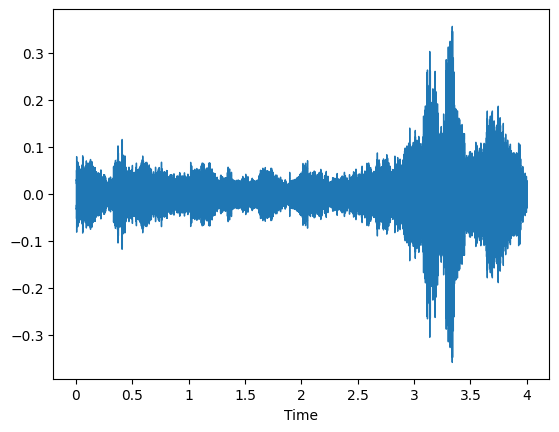

In [229]:
librosa.display.waveshow(librosa_audio_data,sr=librosa_sample_rate)
ipd.Audio(filename)

Here Librosa converts the signal to mono, meaning the channel will alays be 1

scipy

In [230]:
from scipy.io import wavfile as wav
wave_sample_rate,wave_audio = wav.read(filename)

In [231]:
wave_audio

array([[ -29,  -65],
       [-106, -321],
       [-178, -698],
       ...,
       [-317,  127],
       [-150,  355],
       [  48,  583]], dtype=int16)

In [232]:
wave_sample_rate


44100

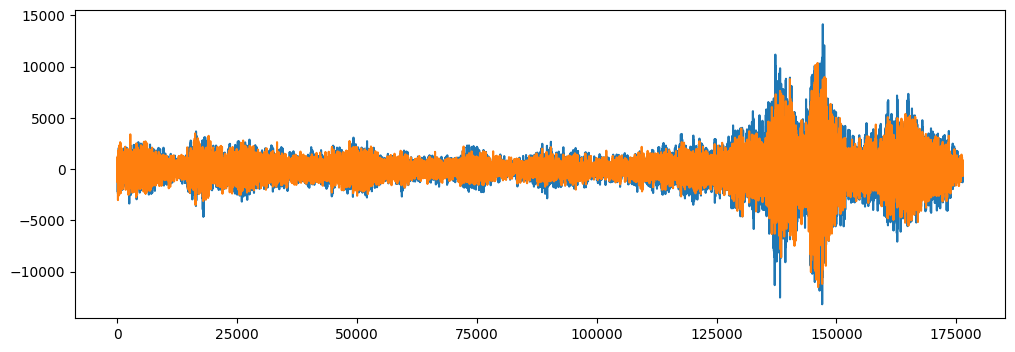

In [233]:
plt.figure(figsize=(12,4))
plt.plot(wave_audio)
plt.show()

Here Scipy converts the signal to stereo, meaning the channels will be 2¶


Metadata

In [234]:
metadata = pd.read_csv('UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [235]:
metadata.shape


(8732, 8)

In [236]:
metadata.isnull().sum()


slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

In [237]:
metadata.duplicated().sum()


0

In [238]:
#check whether the dataset is balanced/imbalanced
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

The data is balanced


Data Visualization

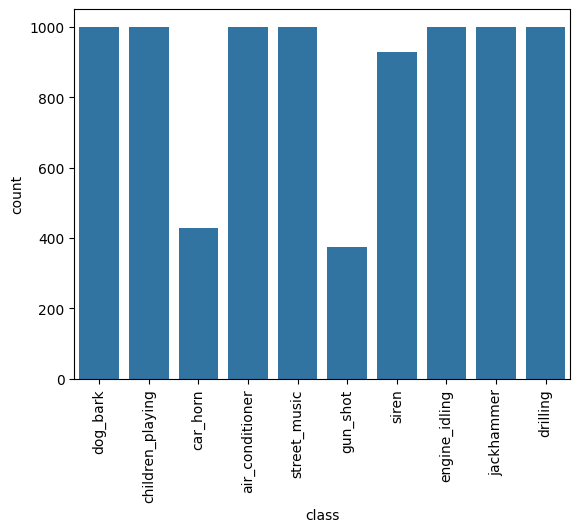

In [239]:
sns.countplot(x='class',data=metadata)
plt.xticks(rotation=90)
plt.show()

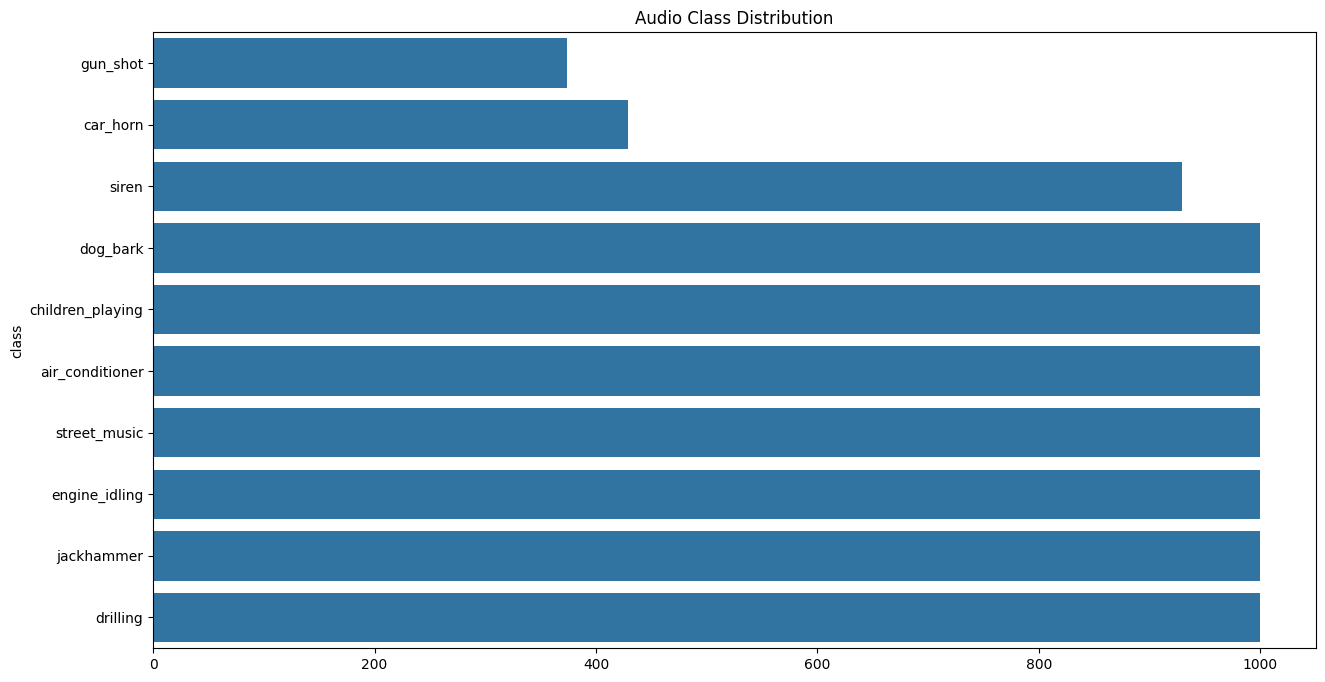

In [240]:
plt.figure(figsize=(15,8))
plt.title('Audio Class Distribution')
class_dist = metadata['class'].value_counts().sort_values()
sns.barplot(x=class_dist.values,
           y=class_dist.keys())
plt.show()

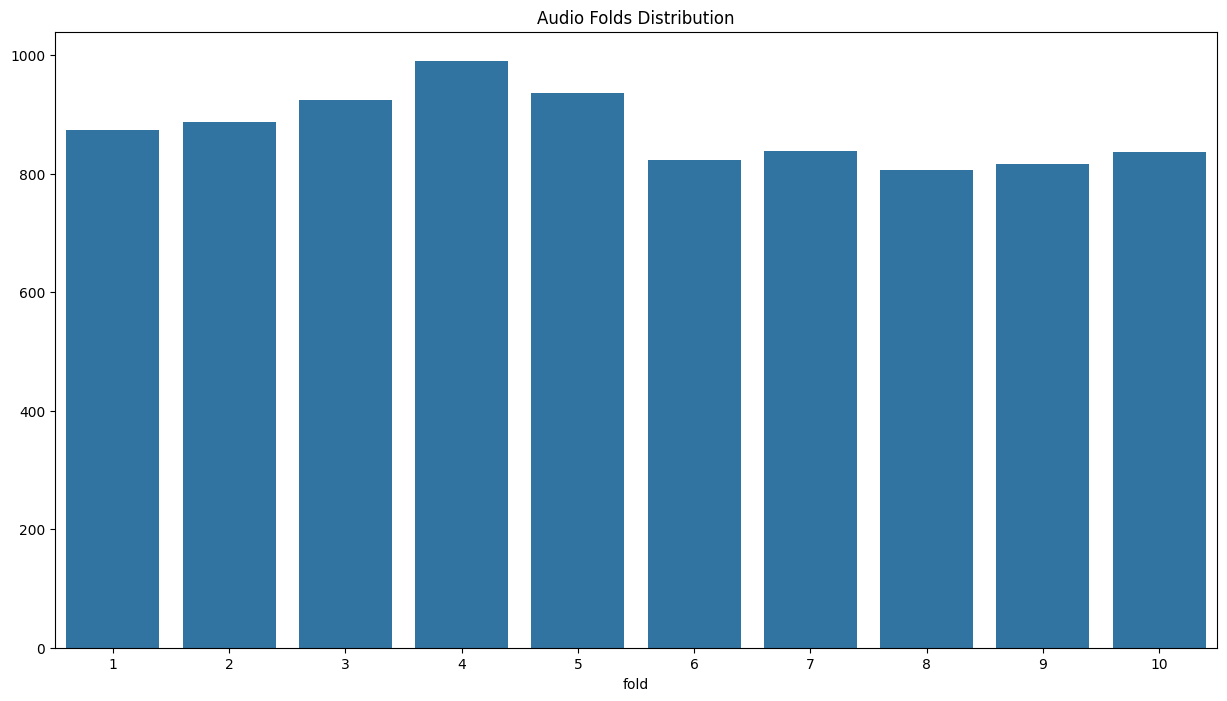

In [241]:
plt.figure(figsize=(15,8))
plt.title('Audio Folds Distribution')
folds_dist = metadata['fold'].value_counts().sort_values()
sns.barplot(y=folds_dist.values,
           x=folds_dist.keys())
plt.show()

Data Preprocessing

Feature Extraction



Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples.
The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound.
These audio representations will allow us to identify features for classification.

In [242]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=50)
mfccs

array([[-250.7297    , -218.86018   , -203.31895   , ..., -220.58408   ,
        -234.88823   , -269.432     ],
       [  86.098236  ,   79.879074  ,   81.53845   , ...,  113.62471   ,
         112.33218   ,  104.04005   ],
       [ -49.641876  ,  -44.56617   ,  -42.068504  , ...,  -37.475483  ,
         -26.145905  ,  -16.622768  ],
       ...,
       [  -7.9525833 ,   -7.009884  ,   -0.2725352 , ...,   11.134181  ,
           5.052047  ,    1.7420287 ],
       [ -10.854351  ,   -9.791126  ,   -7.3976192 , ...,    2.860991  ,
          -1.0604726 ,    0.64140713],
       [   4.687726  ,    3.4185917 ,   -2.193544  , ...,    5.779778  ,
           2.2122502 ,    4.88041   ]], dtype=float32)

In [243]:
mfccs.shape


(50, 173)

This is the preprocessing for a single individual file

In [244]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [245]:
audio_dataset_path='UrbanSound8K'


In [246]:
!pip install tqdm


In [247]:
import os
from tqdm import tqdm

In [248]:
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for i,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])


8732it [02:42, 53.86it/s]


In [249]:
#converting extracted features to pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-211.93698, 62.581207, -122.81315, -60.74528,...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.19586, ...",children_playing
3,"[-406.47922, 91.1966, -25.043558, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690277,...",children_playing


Data Splitting

In [250]:

X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())


In [251]:
X

array([[-2.11936981e+02,  6.25812073e+01, -1.22813148e+02, ...,
         1.23093057e+00, -5.30414534e+00,  2.22270489e+00],
       [-4.17005188e+02,  9.93366241e+01, -4.29955864e+01, ...,
         1.16269374e+00, -1.96495438e+00,  4.15635258e-01],
       [-4.52393158e+02,  1.12362534e+02, -3.75780678e+01, ...,
         6.01064980e-01, -2.65929890e+00,  7.46222675e-01],
       ...,
       [-2.97315338e+02,  1.02090263e+02, -3.67510796e+01, ...,
         2.20239830e+00,  1.95113838e+00, -3.40594947e-01],
       [-3.36923859e+02,  1.15313896e+02, -4.48470955e+01, ...,
         3.53287369e-01, -1.25762618e+00, -1.70473540e+00],
       [-3.07417603e+02,  8.33067322e+01, -2.57565117e+01, ...,
         4.89573526e+00, -4.30078840e+00, -7.42102957e+00]], dtype=float32)

In [252]:
X.shape

(8732, 50)

In [253]:
y.shape

(8732,)

Categorical Encoding

In [254]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [255]:
!pip install tensorflow

Train Test Split

In [256]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=42)

In [257]:
X_train.shape

(7422, 50)

In [258]:
X_test.shape


(1310, 50)

In [259]:
y_train.shape

(7422, 10)

In [260]:
y_test.shape

(1310, 10)

In [261]:
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ",X_test.shape[0])

Number of training samples =  7422
Number of testing samples =  1310


Model Building

In [262]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [263]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report

In [264]:
#No of classes
num_labels = y.shape[1]
num_labels

10

In [265]:
model = Sequential()
# first layer
model.add(Dense(256,input_shape=(50,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# second layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#third layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))

#final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [266]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,826 (698.54 KB)

 Trainable params: 178,826 (698.54 KB)

 Non-trainable params: 0 (0.00 B)

In [267]:
!pip install pydot

In [268]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [269]:
from tensorflow.keras.utils import to_categorical


In [270]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam')

Model Training


In [271]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 150
num_batch_size = 32

In [272]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam'
)


In [273]:
training = model.fit(X_train,
                     y_train,
                     batch_size=num_batch_size,
                     epochs=num_epochs,
                    validation_data=(X_test,y_test))

Epoch 1/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1288 - loss: 16.1280 - val_accuracy: 0.1802 - val_loss: 2.1351
Epoch 2/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2065 - loss: 2.3600 - val_accuracy: 0.2458 - val_loss: 2.0186
Epoch 3/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2701 - loss: 2.0593 - val_accuracy: 0.3206 - val_loss: 1.8518
Epoch 4/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3349 - loss: 1.9008 - val_accuracy: 0.3924 - val_loss: 1.6936
Epoch 5/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3893 - loss: 1.7373 - val_accuracy: 0.4824 - val_loss: 1.5491
Epoch 6/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4263 - loss: 1.6401 - val_accuracy: 0.5214 - val_loss: 1.4455
Epoch 7/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4574 - loss: 1.5615 - val_accuracy: 0.5412 - val_loss: 1.3702
Epoch 8/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4961 - loss: 1.4770 - val_acc

In [298]:
test_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8946564793586731


In [299]:
train_hist = pd.DataFrame(training.history)
train_hist

,accuracy,loss,val_accuracy,val_loss
0,0.142010,7.601924,0.180153,2.135149
1,0.217327,2.270630,0.245802,2.018587
2,0.284155,2.010893,0.320611,1.851798
3,0.342495,1.863860,0.392366,1.693581
4,0.391943,1.727790,0.482443,1.549091
...,...,...,...,...
145,0.847885,0.485863,0.890840,0.403120
146,0.853005,0.475405,0.880916,0.429848
147,0.854082,0.468496,0.895420,0.376986
148,0.854756,0.461097,0.890076,0.390515


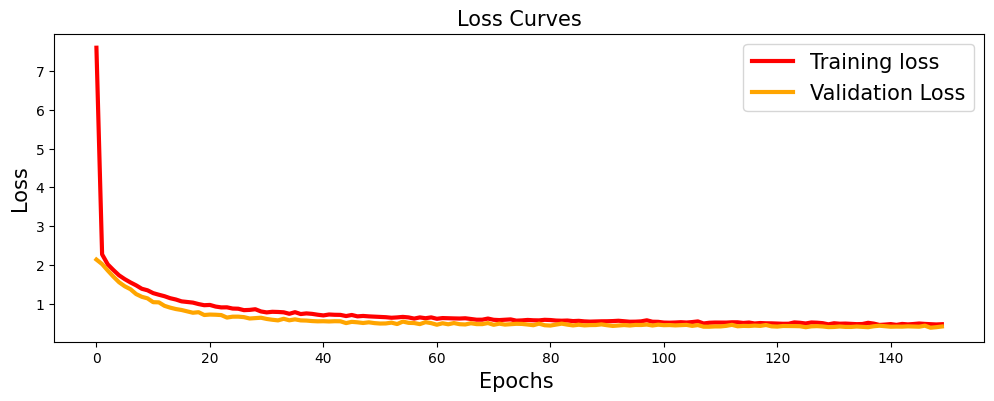

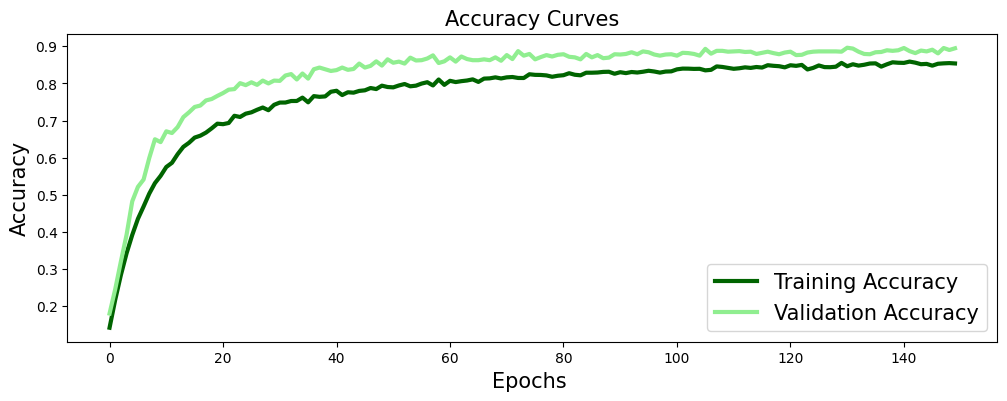

In [300]:
# Loss curves
plt.figure(figsize=[12,4])
plt.plot(training.history['loss'],'red',linewidth=3.0)
plt.plot(training.history['val_loss'],'orange',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=15)
plt.xlabel('Epochs ',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title('Loss Curves',fontsize=15)


# Accuracy Curves
plt.figure(figsize=[12,4])
plt.plot(training.history['accuracy'],'darkgreen',linewidth=3.0)
plt.plot(training.history['val_accuracy'],'lightgreen',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=15)
plt.xlabel('Epochs ',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title('Accuracy Curves',fontsize=15)
plt.show()


In [301]:
ytrue = np.argmax(y_test,axis=1)
ypred = np.argmax(model.predict(X_test),axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [302]:
from sklearn.metrics import confusion_matrix, classification_report
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))


Confusion Matrix :


[[148   0   4   0   0   4   0   0   0   3]
 [  1  54   3   0   1   0   0   1   0   4]
 [  5   0 127   3   0   1   1   0   1   9]
 [  4   1  10 125   1   0   1   0   1   3]
 [  2   0   8   3 133   1   0   3   0   5]
 [  0   0   1   0   0 142   0   0   0   0]
 [  1   0   5   3   1   0  38   0   0   1]
 [  0   0   0   0   2   0   0 146   0   3]
 [  0   0   3   3   0   0   0   0 118   0]
 [  8   1  14   3   0   4   0   1   0 141]]


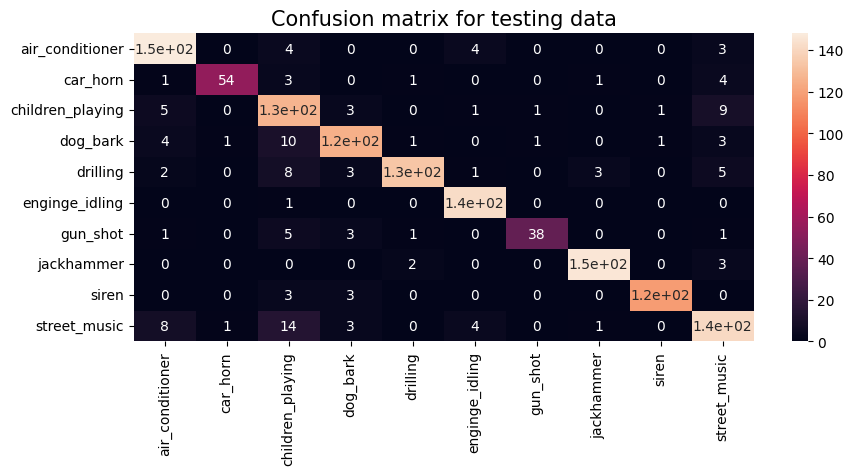

In [303]:
plt.figure(figsize=(10,4))
plt.title("Confusion matrix for testing data", fontsize = 15)
plt.xlabel("Predicted class")
plt.ylabel("True class")
sns.heatmap(confusion_matrix(ytrue,ypred),annot=True,
           xticklabels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'enginge_idling', 'gun_shot', 'jackhammer', 'siren','street_music'],
           yticklabels=['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'enginge_idling', 'gun_shot', 'jackhammer', 'siren','street_music'])

plt.show()

In [304]:
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))



Classification Report : 

               precision    recall  f1-score   support

           0       0.88      0.93      0.90       159
           1       0.96      0.84      0.90        64
           2       0.73      0.86      0.79       147
           3       0.89      0.86      0.87       146
           4       0.96      0.86      0.91       155
           5       0.93      0.99      0.96       143
           6       0.95      0.78      0.85        49
           7       0.97      0.97      0.97       151
           8       0.98      0.95      0.97       124
           9       0.83      0.82      0.83       172

    accuracy                           0.89      1310
   macro avg       0.91      0.89      0.90      1310
weighted avg       0.90      0.89      0.90      1310



Model Prediction

In [305]:
X_test[1]

array([-8.02253342e+00,  1.12755035e+02, -1.81556683e+01,  2.84234829e+01,
       -1.27770786e+01,  6.17681980e+00, -1.18947344e+01,  7.11439180e+00,
       -8.16670036e+00, -3.77119780e+00, -9.78234673e+00, -6.23640156e+00,
       -9.94229698e+00, -5.95497549e-01, -5.51220798e+00, -1.58082604e+00,
       -6.52468920e+00, -2.72377110e+00, -7.19590092e+00, -4.14205599e+00,
       -4.13311434e+00,  4.09037447e+00, -3.42284513e+00, -2.24278855e+00,
       -7.60056782e+00, -2.73272061e+00, -4.65861750e+00, -5.32068670e-01,
       -5.65531158e+00,  2.36052155e+00,  6.71531391e+00,  8.74744320e+00,
        1.12496786e-01,  1.08901489e+00, -3.02489185e+00, -2.23138499e+00,
       -6.67724323e+00,  1.83605301e+00,  6.97077751e-01,  7.63069451e-01,
       -3.75846457e+00,  2.07469010e+00, -7.11396039e-02, -9.65634361e-02,
       -3.35032201e+00,  7.30996370e-01, -1.88804531e+00,  2.61091614e+00,
       -8.73576343e-01, -1.57231462e+00], dtype=float32)

In [306]:
filename = 'UrbanSound8K/fold5/190893-2-0-11.wav'
prediction_feature = features_extractor(filename)
prediction_feature = prediction_feature.reshape(1,-1)
np.argmax(model.predict(prediction_feature),axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([1], dtype=int64)

In [307]:
prediction_feature.shape

(1, 50)

In [308]:
np.argmax(model.predict(X_test),axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([8, 9, 4, ..., 0, 9, 0], dtype=int64)

Testing Some Test Audio Data

In [309]:
filename = "UrbanSound8K/fold8/103076-3-0-0.wav"
audio,sample_rate = librosa.load(filename)
mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=50)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [310]:
mfccs_scaled_features


array([-4.3579456e+02,  5.7867908e+01, -3.1872954e+00, -1.9904032e+01,
       -2.0641861e+01, -2.2496645e+01, -1.9619402e+01, -1.1440505e+01,
       -9.8861074e+00,  4.3746158e-01,  3.6107080e+00,  1.3495114e+00,
        1.5682596e+00,  3.3248961e+00,  5.3259506e+00,  1.6191692e+00,
       -3.5303671e+00, -3.6765375e+00, -6.3732409e+00, -8.6413746e+00,
       -8.3451672e+00, -4.6818123e+00, -2.0709703e+00,  2.4145408e+00,
        1.8110502e+00, -1.0843941e-01, -3.1374373e+00, -3.4383011e+00,
       -4.1745181e+00, -3.9663990e+00, -3.1244626e+00,  5.3930402e-01,
       -6.3234138e-01,  1.0686829e+00,  1.1267067e+00,  2.1163015e+00,
        1.3684055e+00,  7.9674971e-01,  2.0303579e-01, -7.3811364e-01,
       -1.7383384e+00, -1.2268114e+00, -8.8372737e-01,  1.3248517e-01,
        3.6340034e-01,  1.6926569e+00,  1.9031427e+00,  2.2184968e+00,
        1.7511543e+00,  2.6375327e+00], dtype=float32)

In [311]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
mfccs_scaled_features

array([[-4.3579456e+02,  5.7867908e+01, -3.1872954e+00, -1.9904032e+01,
        -2.0641861e+01, -2.2496645e+01, -1.9619402e+01, -1.1440505e+01,
        -9.8861074e+00,  4.3746158e-01,  3.6107080e+00,  1.3495114e+00,
         1.5682596e+00,  3.3248961e+00,  5.3259506e+00,  1.6191692e+00,
        -3.5303671e+00, -3.6765375e+00, -6.3732409e+00, -8.6413746e+00,
        -8.3451672e+00, -4.6818123e+00, -2.0709703e+00,  2.4145408e+00,
         1.8110502e+00, -1.0843941e-01, -3.1374373e+00, -3.4383011e+00,
        -4.1745181e+00, -3.9663990e+00, -3.1244626e+00,  5.3930402e-01,
        -6.3234138e-01,  1.0686829e+00,  1.1267067e+00,  2.1163015e+00,
         1.3684055e+00,  7.9674971e-01,  2.0303579e-01, -7.3811364e-01,
        -1.7383384e+00, -1.2268114e+00, -8.8372737e-01,  1.3248517e-01,
         3.6340034e-01,  1.6926569e+00,  1.9031427e+00,  2.2184968e+00,
         1.7511543e+00,  2.6375327e+00]], dtype=float32)

In [312]:
mfccs_scaled_features.shape


(1, 50)

In [313]:
predicted_label = np.argmax(model.predict(mfccs_scaled_features),axis=1)
predicted_label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


array([3], dtype=int64)

In [314]:
prediction_class = labelencoder.inverse_transform(predicted_label)
prediction_class

array(['dog_bark'], dtype='<U16')

In [315]:
ipd.Audio(filename)


Predictions


In [316]:
def predict(filename):
    audio, sample_rate = librosa.load(filename) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
    predicted_label = np.argmax(model.predict(mfccs_scaled_features),axis=1)
    prediction_class = labelencoder.inverse_transform(predicted_label)
    print(prediction_class)
    return ipd.Audio(filename)


In [317]:
predict('UrbanSound8K/fold8/99179-9-0-38.wav')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
['street_music']


In [318]:
predict('UrbanSound8K/fold9/12812-5-0-0.wav')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
['engine_idling']


In [319]:
predict('UrbanSound8K/fold9/196066-2-0-1.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
['children_playing']


SAVING THE MODEL

In [320]:
model.save('model.h5')


In [321]:
import joblib
joblib.dump(labelencoder, 'labelencoder.joblib')

['labelencoder.joblib']